<a href="https://colab.research.google.com/github/sauravdas093/Kaggle_Challenge/blob/main/3)Decision_Trees_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pixeltests School Data Science

*Unit 2, Sprint 2, Module 1*

---

In [ ]:
%%capture
import sys
import pandas as pd
import numpy as np
# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/pixeltests/datasets/main/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Decision Trees

This week, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

The tasks for this project are as follows:

- **Task 1:** Enter the [Kaggle](https://www.kaggle.com/t/6169ee7701164d24943c98eda2de9b5e) competition using exactly this link!
- **Task 2:** Use `wrangle` function to import training and test data.
- **Task 3:** Split training data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build and train `model_dt`.
- **Task 7:** Calculate the training and validation accuracy score for your model.
- **Task 8:** Adjust model's `max_depth` to reduce overfitting.
- **Task 9 `stretch goal`:** Create a horizontal bar chart showing the 10 most important features for your model.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `sklearn`

# Kaggle

**Task 1:** Enter the [Kaggle](https://www.kaggle.com/t/6169ee7701164d24943c98eda2de9b5e) competition using exactly this link! **We recommend that you choose a username that's based on your name, since you might include it in your resume in the future.**. Go to the **Rules** page. Accept the rules of the competition. Notice that the **Rules** page also has instructions for the Submission process. The **Data** page has feature definitions.

# I. Wrangle Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path,
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path,
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(15).T.duplicated().index
                 if df.head(15).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)

    return df

In [ ]:
def preprocess(df):
    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(15).T.duplicated().index
                 if df.head(15).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)

    return df

**Task 1:** Using the `wrangle` function above, read the `train_features.csv` and  `train_labels.csv` files into the DataFrame `df`. Next, use the same function to read the test set `test_features.csv` into the DataFrame `X_test`.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/demo/train_features.csv',na_values=[0, -2.000000e-08])
labels = pd.read_csv('/content/drive/MyDrive/demo/train_labels.csv',na_values=[0, -2.000000e-08])

In [ ]:
df['status_group']=labels['status_group'].values

In [ ]:
X_test = pd.read_csv('/content/drive/MyDrive/demo/test_features.csv',na_values=[0, -2.000000e-08])


In [ ]:
df = preprocess(df)
X_test = preprocess(X_test)

# II. Split Data

**Task 3:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

In [ ]:
X = df.drop('status_group',axis=1)
y = labels

**Task 4:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [ ]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(df, train_size=0.80, test_size=0.20,
                              stratify=df['status_group'], random_state=42)
# X_train, X_val, y_train, y_val = ..., ..., ..., ...

In [ ]:
X_train = train.drop('status_group',axis=1)
y_train = train['status_group']

In [ ]:
X_val = val.drop('status_group',axis=1)
y_val = val['status_group']

# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [ ]:
majority_class = y_train.mode()[0]
y_pred= [majority_class] * len(y_train)

In [ ]:
from sklearn.metrics import accuracy_score
baseline_acc = accuracy_score(y_train, y_pred)

print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5430871212121212


# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_dt`, and fit it to your training data. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `DecisionTreeClassifier` predictor.

**Note:** Don't forget to set the `random_state` parameter for your `DecisionTreeClassifier`.

In [ ]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline


model_dt = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(random_state=91)
)


In [ ]:
model_dt.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoin...
communal standpipe multiple    2
communal standpipe             3
other                          4
improved spring                5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 'waterpoint_type_group',
                                          'data_type': dtype('O'),
                                          'mapping': hand pump             1
communal standpipe    2
other                 3
improved spring       4
cattle trough         5
dam                   6
NaN                  -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=91))])

# V. Check Metrics

**Task 7:** Calculate the training and validation accuracy scores for `model_dt`.

In [ ]:
training_acc = model_dt.score(X_train, y_train)
val_acc = model_dt.score(X_val, y_val)
print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 1.0
Validation Accuracy Score: 0.734006734006734


# VI. Tune Model

**Task 8:** Is there a large difference between your training and validation accuracy? If so, experiment with different setting for `max_depth` in your `DecisionTreeClassifier` to reduce the amount of overfitting in your model.

In [ ]:
# Use this cell to experiment and then change
# your model hyperparameters in Task 6

model_dt1 = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(max_depth = 13, random_state=91)
)
model_dt1.fit(X_train, y_train)

training_acc1 = model_dt1.score(X_train, y_train)
val_acc1 = model_dt1.score(X_val, y_val)
print('Training Accuracy Score:', training_acc1)
print('Validation Accuracy Score:', val_acc1)

Training Accuracy Score: 0.813236531986532
Validation Accuracy Score: 0.7554713804713805


# VII. Communicate Results

**Task 9 `stretch goal`:** Create a horizontal barchart that shows the the 10 most important features for model_dt, sorted by value.

**Note:** [`DecisionTreeClassifier.feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontreecla#sklearn.tree.DecisionTreeClassifier.feature_importances_) returns values that are different from [`LogisticRegression.coef_`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). All the values will be positive, and they will sum to `1`.

<Axes: >

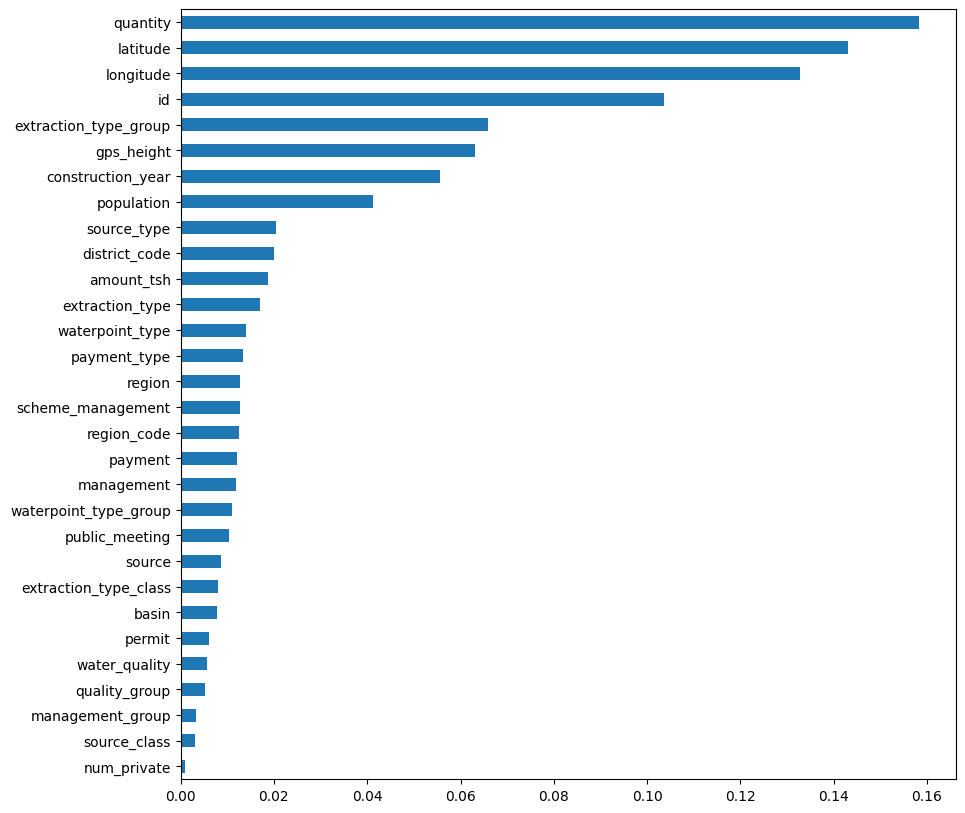

In [ ]:
import matplotlib.pyplot as plt

model = model_dt.named_steps['decisiontreeclassifier']
encoder = model_dt.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,10))
importances.sort_values().plot.barh()

In [ ]:
# FOR KAGGLE SUBMISSION

y_pred= model_dt.predict(X_test)
y_pred.shape

(11880,)

In [ ]:
sample = pd.read_csv('/content/drive/MyDrive/demo/tanzania sample solution.csv')

# Making Copy as accurate column as per sample submission
submission = sample[['S.No.']].copy() #get the id and the prediction
submission['status_group'] = y_pred


#Code Chunk for setting legend functional - 0, functional needs repair - 1, non functional - 2
submission['status_group1'] = submission[['status_group']]
submission = submission.set_index("status_group1")
submission.loc[['functional'], ['status_group']] = 0
submission.loc[['functional needs repair'], ['status_group']] = 1
submission.loc[['non functional'], ['status_group']] = 2
submission = submission.reset_index()
submission = submission.drop('status_group1',axis=1)
submission

#Creating final csv file for kaggle submission

submission.to_csv('Tanzania_water_pump-01.csv', index=False)


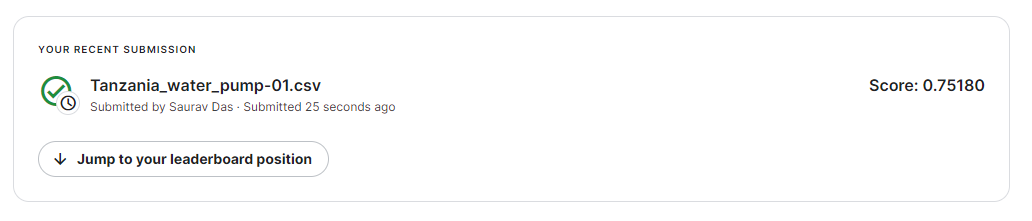

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/demo/Predict-faulty-Tanzania-Water-Pumps-Kaggle.png')

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(multi_class='auto')
)

# fit on train
pipeline.fit(X_train, y_train)

#score on validation
print('Validation Accuracy', pipeline.score(X_val, y_val))

#predict on test
y_pred = pipeline.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Accuracy 0.7408459595959596


In [ ]:
y_pred.shape

(11880,)

In [ ]:
sample = pd.read_csv('/content/drive/MyDrive/tanzania sample solution (1).csv')
submission = sample[['S.No.']].copy() #get the id and the prediction
submission['status_group'] = y_pred


#Code Chunk for setting legend functional - 0, functional needs repair - 1, non functional - 2
submission['status_group1'] = submission[['status_group']]
submission = submission.set_index("status_group1")
submission.loc[['functional'], ['status_group']] = 0
submission.loc[['functional needs repair'], ['status_group']] = 1
submission.loc[['non functional'], ['status_group']] = 2
submission = submission.reset_index()
submission = submission.drop('status_group1',axis=1)
submission

,S.No.,status_group
0,1,0
1,2,0
2,3,0
3,4,2
4,5,0
...,...,...
11875,11876,2
11876,11877,2
11877,11878,2
11878,11879,0


In [ ]:
submission.to_csv('Tanzania_water_pump_logistic.csv', index=False)